# ANALISIS COMPLETO DE PRECISION DE LA AI

## Dos metricas de evaluacion:

### 1. Precision por CAMPO
- Coincidencias (API=CSV) + Correcciones donde AI acerto (ERROR_CSV, AMBOS_CORRECTOS)
- Mas granular, muestra rendimiento por cada campo

### 2. Precision por PDF (estricta)
- Un PDF con >= 1 campo incorrecto = PDF MALO
- Refleja la realidad del negocio: si 1 campo falla, la cotizacion esta mal

---

In [47]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerias cargadas OK")

Librerias cargadas OK


In [48]:
# Cargar datos
with open('resultados_api.json', 'r', encoding='utf-8') as f:
    resultados_api = json.load(f)

with open('revision_manual.json', 'r', encoding='utf-8') as f:
    revision_manual = json.load(f)

# Constantes
TOTAL_PEDIDOS = 200
PEDIDOS_COINCIDENTES = 126  # API = CSV en todos los campos
PEDIDOS_REVISADOS = 74      # Tuvieron al menos 1 diferencia

# Datos de comparacion original (de los 200 pedidos)
COMPARACION_ORIGINAL = {
    'moneda': {'coincidieron': 196, 'diferencias': 4},
    'ruc': {'coincidieron': 156, 'diferencias': 44},
    'proveedor': {'coincidieron': 190, 'diferencias': 10},
    'igv': {'coincidieron': 161, 'diferencias': 39},
    'sub_total': {'coincidieron': 186, 'diferencias': 14},
    'total': {'coincidieron': 148, 'diferencias': 52}
}

print(f"Total pedidos: {TOTAL_PEDIDOS}")
print(f"Coincidieron (API=CSV): {PEDIDOS_COINCIDENTES}")
print(f"Revisados manualmente: {PEDIDOS_REVISADOS}")

Total pedidos: 200
Coincidieron (API=CSV): 126
Revisados manualmente: 74


In [49]:
# Crear DataFrame de campos revisados
rows = []
for revision in revision_manual['revisiones']:
    for campo in revision['campos_revisados']:
        rows.append({
            'pedido': revision['pedido'],
            'tipo_pdf': revision['tipo_pdf'],
            'hubo_varios_pdfs': revision['hubo_varios_pdfs'],
            'campo': campo['campo'],
            'valor_csv': campo['valor_csv'],
            'valor_api': campo['valor_api'],
            'causa_error': campo['causa_error'],
            'valor_correcto_es': campo['valor_correcto_es']
        })

df_revision = pd.DataFrame(rows)

print(f"Total campos revisados: {len(df_revision)}")
print(f"\nDistribucion de causas de error:")
print(df_revision['causa_error'].value_counts())

Total campos revisados: 163

Distribucion de causas de error:
causa_error
ERROR_CSV          115
ERROR_IA            21
NO_DETERMINADO      14
AMBOS_CORRECTOS     11
PDF_ILEGIBLE         2
Name: count, dtype: int64


---
# 1. PRECISION POR CAMPO
## Formula: (Coincidencias + ERROR_CSV + AMBOS_CORRECTOS) / Total Evaluable
---

In [50]:
# Calcular precision REAL por campo
# Aciertos = Coincidencias originales + ERROR_CSV + AMBOS_CORRECTOS
# Errores = ERROR_IA

precision_por_campo = {}

for campo in COMPARACION_ORIGINAL.keys():
    # Datos originales
    coincidieron = COMPARACION_ORIGINAL[campo]['coincidieron']
    
    # De la revision manual
    revision_campo = df_revision[df_revision['campo'] == campo]
    error_csv = len(revision_campo[revision_campo['causa_error'] == 'ERROR_CSV'])
    ambos_ok = len(revision_campo[revision_campo['causa_error'] == 'AMBOS_CORRECTOS'])
    error_ia = len(revision_campo[revision_campo['causa_error'] == 'ERROR_IA'])
    no_det = len(revision_campo[revision_campo['causa_error'] == 'NO_DETERMINADO'])
    ilegible = len(revision_campo[revision_campo['causa_error'] == 'PDF_ILEGIBLE'])
    
    # Calculos
    aciertos_ai = coincidieron + error_csv + ambos_ok
    errores_ai = error_ia
    total_evaluable = aciertos_ai + errores_ai
    precision = (aciertos_ai / total_evaluable * 100) if total_evaluable > 0 else 0
    
    precision_por_campo[campo] = {
        'coincidieron': coincidieron,
        'error_csv': error_csv,
        'ambos_ok': ambos_ok,
        'error_ia': errores_ai,
        'no_det': no_det,
        'ilegible': ilegible,
        'aciertos_ai': aciertos_ai,
        'errores_ai': errores_ai,
        'total_evaluable': total_evaluable,
        'precision': round(precision, 2)
    }

df_campo = pd.DataFrame(precision_por_campo).T

print("PRECISION POR CAMPO")
print("="*100)
print("\nFormula: (Coincidieron + ERROR_CSV + AMBOS_OK) / (Coincidieron + ERROR_CSV + AMBOS_OK + ERROR_IA)")
print()
display(df_campo[['coincidieron', 'error_csv', 'ambos_ok', 'error_ia', 'aciertos_ai', 'errores_ai', 'precision']])

PRECISION POR CAMPO

Formula: (Coincidieron + ERROR_CSV + AMBOS_OK) / (Coincidieron + ERROR_CSV + AMBOS_OK + ERROR_IA)



,coincidieron,error_csv,ambos_ok,error_ia,aciertos_ai,errores_ai,precision
moneda,196.0,0.0,0.0,3.0,196.0,3.0,98.49
ruc,156.0,38.0,1.0,2.0,195.0,2.0,98.98
proveedor,190.0,0.0,8.0,1.0,198.0,1.0,99.50
igv,161.0,37.0,1.0,1.0,199.0,1.0,99.50
sub_total,186.0,3.0,0.0,6.0,189.0,6.0,96.92
total,148.0,37.0,1.0,8.0,186.0,8.0,95.88


In [51]:
# Precision global por campo
total_aciertos_campo = df_campo['aciertos_ai'].sum()
total_errores_campo = df_campo['errores_ai'].sum()
total_evaluable_campo = df_campo['total_evaluable'].sum()
precision_global_campo = (total_aciertos_campo / total_evaluable_campo * 100)

print(f"\nRESUMEN PRECISION POR CAMPO:")
print("="*50)
print(f"Total aciertos AI:  {int(total_aciertos_campo)}")
print(f"Total errores AI:   {int(total_errores_campo)}")
print(f"Total evaluable:    {int(total_evaluable_campo)}")
print(f"\n>>> PRECISION GLOBAL POR CAMPO: {precision_global_campo:.2f}% <<<")


RESUMEN PRECISION POR CAMPO:
Total aciertos AI:  1163
Total errores AI:   21
Total evaluable:    1184

>>> PRECISION GLOBAL POR CAMPO: 98.23% <<<


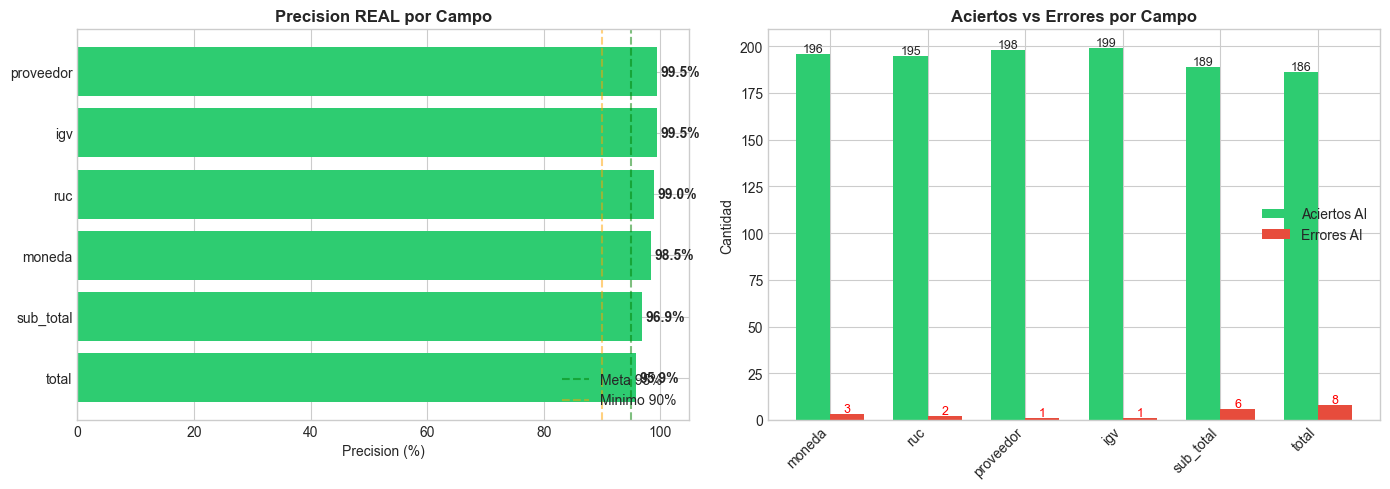

In [52]:
# Grafico de precision por campo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Precision por campo
df_sorted = df_campo.sort_values('precision')
colors = ['#e74c3c' if p < 90 else '#f39c12' if p < 95 else '#2ecc71' for p in df_sorted['precision']]
bars = axes[0].barh(df_sorted.index, df_sorted['precision'], color=colors)
axes[0].set_xlim(0, 105)
axes[0].set_xlabel('Precision (%)')
axes[0].set_title('Precision REAL por Campo', fontweight='bold', fontsize=12)
axes[0].axvline(x=95, color='green', linestyle='--', alpha=0.5, label='Meta 95%')
axes[0].axvline(x=90, color='orange', linestyle='--', alpha=0.5, label='Minimo 90%')
for bar in bars:
    w = bar.get_width()
    axes[0].text(w + 0.5, bar.get_y() + bar.get_height()/2, f'{w:.1f}%', va='center', fontweight='bold')
axes[0].legend(loc='lower right')

# Grafico 2: Aciertos vs Errores por campo
x = np.arange(len(df_campo.index))
width = 0.35
axes[1].bar(x - width/2, df_campo['aciertos_ai'], width, label='Aciertos AI', color='#2ecc71')
axes[1].bar(x + width/2, df_campo['errores_ai'], width, label='Errores AI', color='#e74c3c')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_campo.index, rotation=45, ha='right')
axes[1].set_ylabel('Cantidad')
axes[1].set_title('Aciertos vs Errores por Campo', fontweight='bold', fontsize=12)
axes[1].legend()

# Agregar valores
for i, (aciertos, errores) in enumerate(zip(df_campo['aciertos_ai'], df_campo['errores_ai'])):
    axes[1].text(i - width/2, aciertos + 1, str(int(aciertos)), ha='center', fontsize=9)
    if errores > 0:
        axes[1].text(i + width/2, errores + 1, str(int(errores)), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.savefig('graficos/01_precision_por_campo.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 2. PRECISION POR PDF (Estricta)
## Un PDF con >= 1 campo mal = PDF incorrecto
---

In [53]:
# Evaluar cada PEDIDO
pedidos_resultado = []

for revision in revision_manual['revisiones']:
    pedido = revision['pedido']
    tipo_pdf = revision['tipo_pdf']
    campos = revision['campos_revisados']
    
    causas = [c['causa_error'] for c in campos]
    
    tiene_error_ia = 'ERROR_IA' in causas
    tiene_no_det = 'NO_DETERMINADO' in causas
    tiene_ilegible = 'PDF_ILEGIBLE' in causas
    
    # Estado del PDF
    if tiene_error_ia:
        estado = 'AI_FALLO'
    elif tiene_no_det:
        estado = 'NO_DETERMINADO'
    elif tiene_ilegible:
        estado = 'PDF_ILEGIBLE'
    else:
        estado = 'AI_ACERTO'
    
    campos_con_error = [c['campo'] for c in campos if c['causa_error'] == 'ERROR_IA']
    
    pedidos_resultado.append({
        'pedido': pedido,
        'tipo_pdf': tipo_pdf,
        'estado': estado,
        'num_campos_error': len(campos_con_error),
        'campos_con_error': ', '.join(campos_con_error) if campos_con_error else '-'
    })

df_pedidos = pd.DataFrame(pedidos_resultado)

print("RESULTADO POR PEDIDO (de los 74 revisados):")
print("="*50)
print(df_pedidos['estado'].value_counts())

RESULTADO POR PEDIDO (de los 74 revisados):
estado
AI_ACERTO         58
AI_FALLO          10
NO_DETERMINADO     5
PDF_ILEGIBLE       1
Name: count, dtype: int64


In [54]:
# Conteos
pdfs_ai_acerto = len(df_pedidos[df_pedidos['estado'] == 'AI_ACERTO'])
pdfs_ai_fallo = len(df_pedidos[df_pedidos['estado'] == 'AI_FALLO'])
pdfs_no_det = len(df_pedidos[df_pedidos['estado'] == 'NO_DETERMINADO'])
pdfs_ilegible = len(df_pedidos[df_pedidos['estado'] == 'PDF_ILEGIBLE'])

# Precision por PDF
total_correctos_pdf = PEDIDOS_COINCIDENTES + pdfs_ai_acerto
total_incorrectos_pdf = pdfs_ai_fallo
total_evaluable_pdf = total_correctos_pdf + total_incorrectos_pdf

precision_pdf = (total_correctos_pdf / total_evaluable_pdf * 100)

print("\n" + "="*60)
print("PRECISION POR PDF")
print("="*60)
print(f"\nDe los 74 pedidos revisados:")
print(f"   AI acerto (todos campos OK):    {pdfs_ai_acerto}")
print(f"   AI fallo (>= 1 campo mal):      {pdfs_ai_fallo}")
print(f"   No determinado:                 {pdfs_no_det}")
print(f"   PDF ilegible:                   {pdfs_ilegible}")
print(f"\nCalculo:")
print(f"   PDFs correctos: {total_correctos_pdf} ({PEDIDOS_COINCIDENTES} coincidieron + {pdfs_ai_acerto} revisados OK)")
print(f"   PDFs con error: {total_incorrectos_pdf}")
print(f"   Total evaluable: {total_evaluable_pdf}")
print(f"\n>>> PRECISION POR PDF: {precision_pdf:.2f}% <<<")
print("="*60)


PRECISION POR PDF

De los 74 pedidos revisados:
   AI acerto (todos campos OK):    58
   AI fallo (>= 1 campo mal):      10
   No determinado:                 5
   PDF ilegible:                   1

Calculo:
   PDFs correctos: 184 (126 coincidieron + 58 revisados OK)
   PDFs con error: 10
   Total evaluable: 194

>>> PRECISION POR PDF: 94.85% <<<


In [55]:
# PDFs con error - Lista completa
pdfs_error = df_pedidos[df_pedidos['estado'] == 'AI_FALLO'].copy()

print(f"\nLOS {len(pdfs_error)} PDFs CON ERROR:")
print("="*80)
display(pdfs_error[['pedido', 'tipo_pdf', 'num_campos_error', 'campos_con_error']])


LOS 10 PDFs CON ERROR:


,pedido,tipo_pdf,num_campos_error,campos_con_error
3,2026000174,PDF_ESCANEADO,2,"sub_total, total"
4,2026000173,PDF_ESPECIAL,2,"sub_total, total"
12,2026000121,PDF_ESPECIAL,2,"sub_total, total"
13,2026000120,PDF_ESPECIAL,2,"sub_total, total"
37,2025009720,PDF_NORMAL,1,proveedor
43,2025009691,PDF_ESCANEADO,2,"igv, total"
54,2025009640,PDF_NORMAL,1,moneda
62,2025009624,PDF_NORMAL,1,total
72,2025009578,PDF_NORMAL,4,"moneda, ruc, sub_total, total"
73,2025009576,PDF_ESCANEADO,4,"moneda, ruc, sub_total, total"


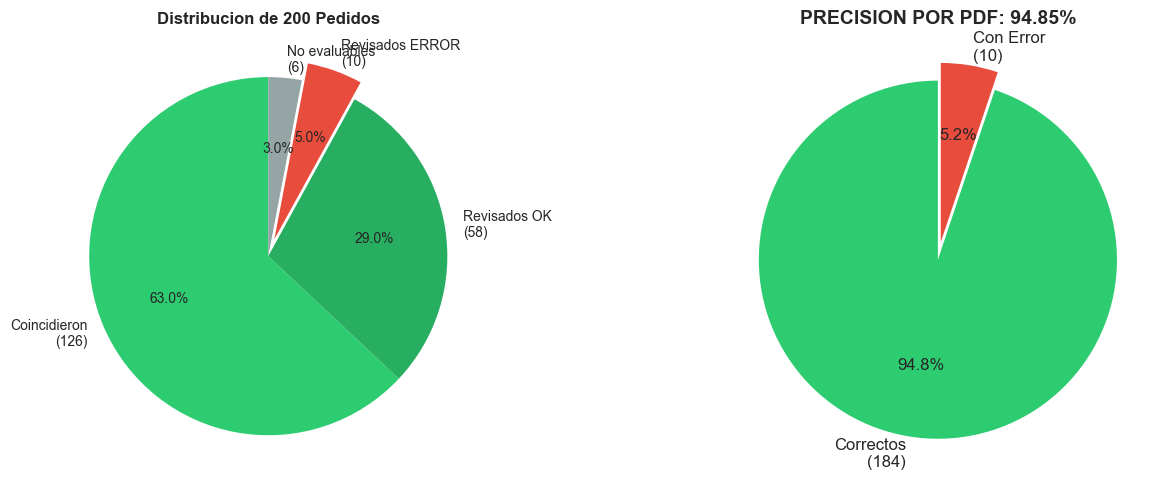

In [56]:
# Grafico de precision por PDF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Distribucion de 200 pedidos
sizes = [PEDIDOS_COINCIDENTES, pdfs_ai_acerto, pdfs_ai_fallo, pdfs_no_det + pdfs_ilegible]
labels = [f'Coincidieron\n({PEDIDOS_COINCIDENTES})', f'Revisados OK\n({pdfs_ai_acerto})', 
          f'Revisados ERROR\n({pdfs_ai_fallo})', f'No evaluables\n({pdfs_no_det + pdfs_ilegible})']
colors = ['#2ecc71', '#27ae60', '#e74c3c', '#95a5a6']
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0,0,0.1,0))
axes[0].set_title('Distribucion de 200 Pedidos', fontweight='bold', fontsize=12)

# Grafico 2: PDFs Correctos vs Con Error
axes[1].pie([total_correctos_pdf, total_incorrectos_pdf], 
        labels=[f'Correctos\n({total_correctos_pdf})', f'Con Error\n({total_incorrectos_pdf})'],
        colors=['#2ecc71', '#e74c3c'], autopct='%1.1f%%', startangle=90, explode=(0.02, 0.08),
        textprops={'fontsize': 12})
axes[1].set_title(f'PRECISION POR PDF: {precision_pdf:.2f}%', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('graficos/02_precision_por_pdf.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 3. COMPARACION DE METRICAS
---

In [57]:
print("\n" + "="*70)
print("COMPARACION DE METRICAS")
print("="*70)
print(f"\n{'Metrica':<40} {'Precision':>15}")
print("-"*55)
print(f"{'Precision por CAMPO (global)':<40} {precision_global_campo:>14.2f}%")
print(f"{'Precision por PDF (estricta)':<40} {precision_pdf:>14.2f}%")
print("-"*55)
print(f"{'Diferencia':<40} {precision_global_campo - precision_pdf:>14.2f}%")
print("\nNota: La precision por PDF es mas baja porque")
print("      un solo campo mal invalida todo el documento.")


COMPARACION DE METRICAS

Metrica                                        Precision
-------------------------------------------------------
Precision por CAMPO (global)                      98.23%
Precision por PDF (estricta)                      94.85%
-------------------------------------------------------
Diferencia                                         3.38%

Nota: La precision por PDF es mas baja porque
      un solo campo mal invalida todo el documento.


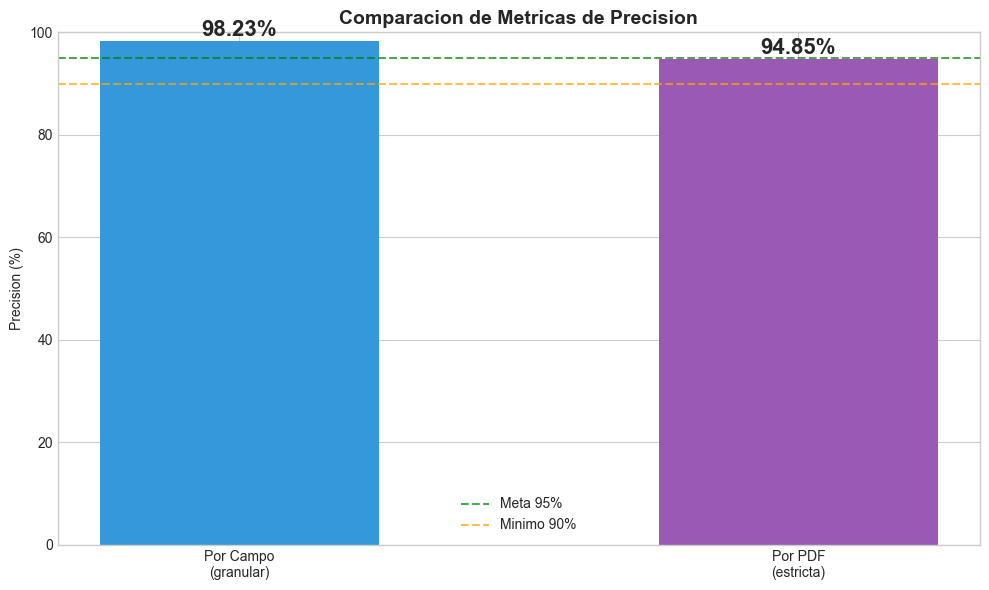

In [58]:
# Grafico comparativo
fig, ax = plt.subplots(figsize=(10, 6))

metricas = ['Por Campo\n(granular)', 'Por PDF\n(estricta)']
valores = [precision_global_campo, precision_pdf]
colores = ['#3498db', '#9b59b6']

bars = ax.bar(metricas, valores, color=colores, width=0.5)
ax.set_ylim(0, 100)
ax.set_ylabel('Precision (%)')
ax.set_title('Comparacion de Metricas de Precision', fontweight='bold', fontsize=14)
ax.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='Meta 95%')
ax.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='Minimo 90%')

for bar, val in zip(bars, valores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{val:.2f}%', ha='center', fontsize=16, fontweight='bold')

ax.legend()
plt.tight_layout()
plt.savefig('graficos/03_comparacion_metricas.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 4. PRECISION POR TIPO DE PDF
---

In [59]:
# Precision por tipo de PDF (de los revisados)
tipos_stats = df_pedidos.groupby('tipo_pdf').agg({
    'pedido': 'count',
    'estado': lambda x: (x == 'AI_FALLO').sum()
}).rename(columns={'pedido': 'total_revisados', 'estado': 'con_error'})

tipos_stats['sin_error'] = tipos_stats['total_revisados'] - tipos_stats['con_error']
tipos_stats['precision'] = ((tipos_stats['sin_error'] / tipos_stats['total_revisados']) * 100).round(2)

print("PRECISION POR TIPO DE PDF (solo revisados):")
print("="*70)
display(tipos_stats)

PRECISION POR TIPO DE PDF (solo revisados):


,total_revisados,con_error,sin_error,precision
tipo_pdf,,,,
NO_DETERMINADO,1,0,1,100.00
PDF_ESCANEADO,19,3,16,84.21
PDF_ESPECIAL,4,3,1,25.00
PDF_NORMAL,50,4,46,92.00


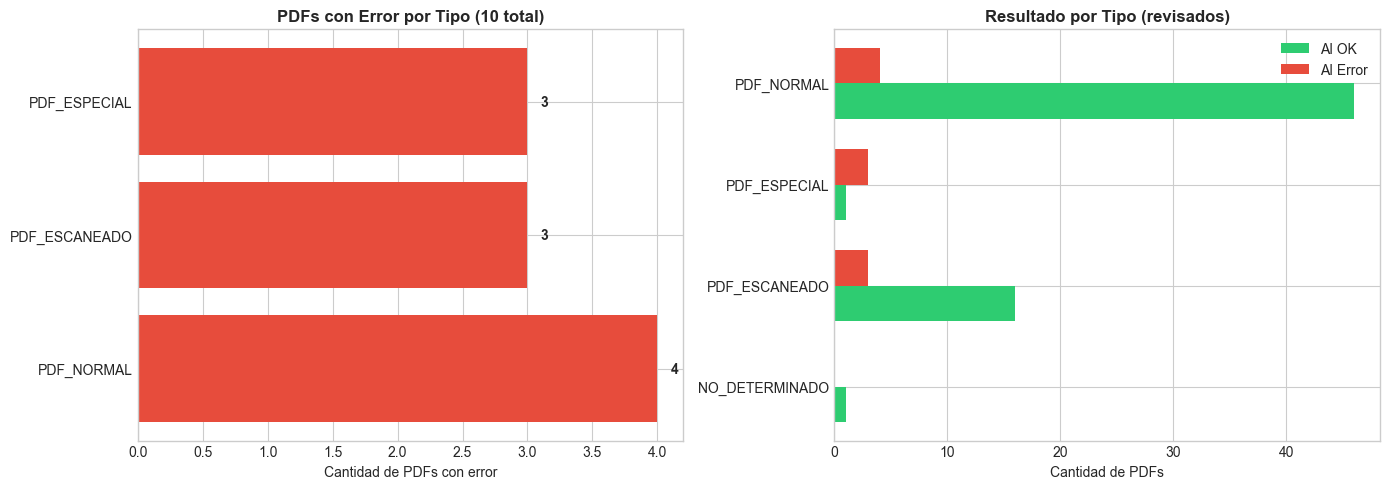

In [60]:
# Grafico por tipo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: PDFs con error por tipo
if len(pdfs_error) > 0:
    tipos_error = pdfs_error['tipo_pdf'].value_counts()
    bars = axes[0].barh(tipos_error.index, tipos_error.values, color='#e74c3c')
    axes[0].set_xlabel('Cantidad de PDFs con error')
    axes[0].set_title(f'PDFs con Error por Tipo ({len(pdfs_error)} total)', fontweight='bold')
    for bar in bars:
        w = bar.get_width()
        axes[0].text(w + 0.1, bar.get_y() + bar.get_height()/2, str(int(w)), va='center', fontweight='bold')

# Grafico 2: OK vs Error por tipo
x = np.arange(len(tipos_stats.index))
width = 0.35
axes[1].barh(x - width/2, tipos_stats['sin_error'], width, label='AI OK', color='#2ecc71')
axes[1].barh(x + width/2, tipos_stats['con_error'], width, label='AI Error', color='#e74c3c')
axes[1].set_yticks(x)
axes[1].set_yticklabels(tipos_stats.index)
axes[1].set_xlabel('Cantidad de PDFs')
axes[1].set_title('Resultado por Tipo (revisados)', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('graficos/04_precision_por_tipo.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 5. ANALISIS DETALLADO DE ERRORES
---

In [61]:
# Errores de IA
errores_ia = df_revision[df_revision['causa_error'] == 'ERROR_IA']

print(f"DETALLE DE ERRORES DE LA AI ({len(errores_ia)} campos en {len(pdfs_error)} PDFs)")
print("="*90)

print(f"\nErrores por campo:")
print(errores_ia['campo'].value_counts())

print(f"\nErrores por tipo de PDF:")
print(errores_ia['tipo_pdf'].value_counts())

DETALLE DE ERRORES DE LA AI (21 campos en 10 PDFs)

Errores por campo:
campo
total        8
sub_total    6
moneda       3
ruc          2
igv          1
proveedor    1
Name: count, dtype: int64

Errores por tipo de PDF:
tipo_pdf
PDF_ESCANEADO    8
PDF_NORMAL       7
PDF_ESPECIAL     6
Name: count, dtype: int64


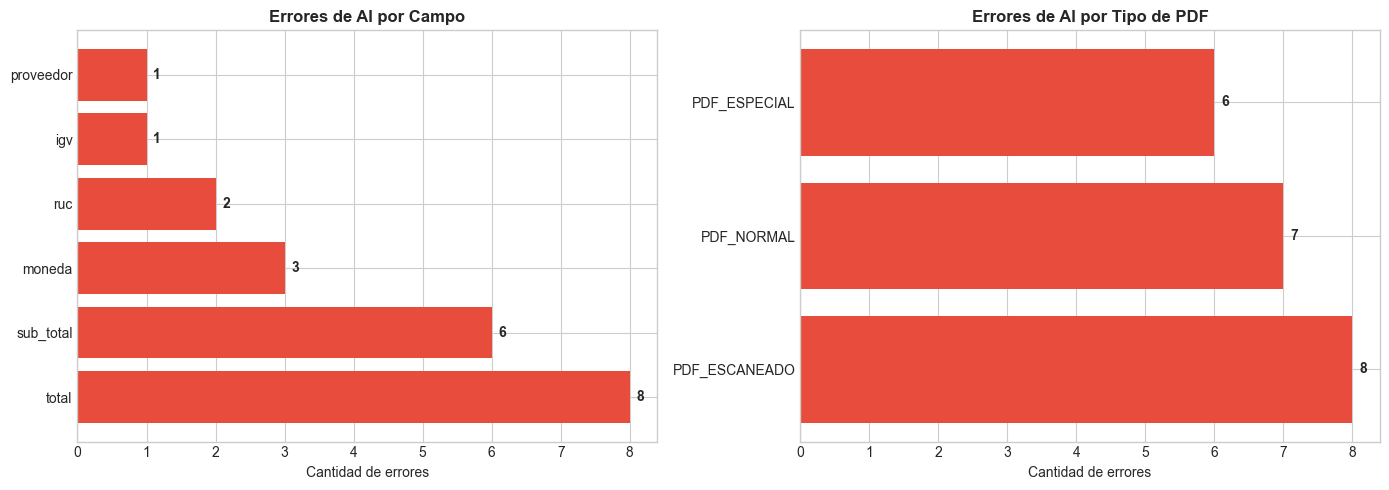

In [62]:
# Grafico de errores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Errores por campo
errores_por_campo = errores_ia['campo'].value_counts()
bars1 = axes[0].barh(errores_por_campo.index, errores_por_campo.values, color='#e74c3c')
axes[0].set_xlabel('Cantidad de errores')
axes[0].set_title('Errores de AI por Campo', fontweight='bold')
for bar in bars1:
    w = bar.get_width()
    axes[0].text(w + 0.1, bar.get_y() + bar.get_height()/2, str(int(w)), va='center', fontweight='bold')

# Errores por tipo PDF
errores_por_tipo = errores_ia['tipo_pdf'].value_counts()
bars2 = axes[1].barh(errores_por_tipo.index, errores_por_tipo.values, color='#e74c3c')
axes[1].set_xlabel('Cantidad de errores')
axes[1].set_title('Errores de AI por Tipo de PDF', fontweight='bold')
for bar in bars2:
    w = bar.get_width()
    axes[1].text(w + 0.1, bar.get_y() + bar.get_height()/2, str(int(w)), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos/05_distribucion_errores.png', dpi=150, bbox_inches='tight')
plt.show()

In [63]:
# Detalle de cada PDF con error
print(f"\nDETALLE DE LOS {len(pdfs_error)} PDFs CON ERROR:")
print("="*90)

for _, pdf in pdfs_error.iterrows():
    print(f"\n--- {pdf['pedido']} ({pdf['tipo_pdf']}) ---")
    print(f"    Campos con error: {pdf['campos_con_error']}")
    
    errores_pdf = errores_ia[errores_ia['pedido'] == pdf['pedido']]
    for _, err in errores_pdf.iterrows():
        api_val = str(err['valor_api'])[:50] if err['valor_api'] else 'null'
        print(f"\n    {err['campo'].upper()}:")
        print(f"      Correcto (CSV): {err['valor_csv']}")
        print(f"      Incorrecto (AI): {api_val}")


DETALLE DE LOS 10 PDFs CON ERROR:

--- 2026000174 (PDF_ESCANEADO) ---
    Campos con error: sub_total, total

    SUB_TOTAL:
      Correcto (CSV): 1500
      Incorrecto (AI): 1900.00

    TOTAL:
      Correcto (CSV): 1770
      Incorrecto (AI): 1900.00

--- 2026000173 (PDF_ESPECIAL) ---
    Campos con error: sub_total, total

    SUB_TOTAL:
      Correcto (CSV): 120
      Incorrecto (AI): 1900.00

    TOTAL:
      Correcto (CSV): 141.6
      Incorrecto (AI): 1900.00

--- 2026000121 (PDF_ESPECIAL) ---
    Campos con error: sub_total, total

    SUB_TOTAL:
      Correcto (CSV): 450
      Incorrecto (AI): 750.00

    TOTAL:
      Correcto (CSV): 531
      Incorrecto (AI): 885.00

--- 2026000120 (PDF_ESPECIAL) ---
    Campos con error: sub_total, total

    SUB_TOTAL:
      Correcto (CSV): 200
      Incorrecto (AI): 280.00

    TOTAL:
      Correcto (CSV): 236
      Incorrecto (AI): 330.40

--- 2025009720 (PDF_NORMAL) ---
    Campos con error: proveedor

    PROVEEDOR:
      Correcto (CSV

---
# 6. ANALISIS DE CAUSAS
---

In [64]:
# Distribucion de causas general
print("DISTRIBUCION DE CAUSAS DE ERROR EN REVISION MANUAL")
print("="*60)

causas_count = df_revision['causa_error'].value_counts()
print(causas_count)

print("\nInterpretacion:")
print("- ERROR_CSV: El CSV estaba mal, la AI tenia razon")
print("- ERROR_IA: La AI se equivoco")
print("- AMBOS_CORRECTOS: Ambos valores son validos")
print("- NO_DETERMINADO: No se pudo determinar cual es correcto")
print("- PDF_ILEGIBLE: El PDF no se puede leer correctamente")

DISTRIBUCION DE CAUSAS DE ERROR EN REVISION MANUAL
causa_error
ERROR_CSV          115
ERROR_IA            21
NO_DETERMINADO      14
AMBOS_CORRECTOS     11
PDF_ILEGIBLE         2
Name: count, dtype: int64

Interpretacion:
- ERROR_CSV: El CSV estaba mal, la AI tenia razon
- ERROR_IA: La AI se equivoco
- AMBOS_CORRECTOS: Ambos valores son validos
- NO_DETERMINADO: No se pudo determinar cual es correcto
- PDF_ILEGIBLE: El PDF no se puede leer correctamente


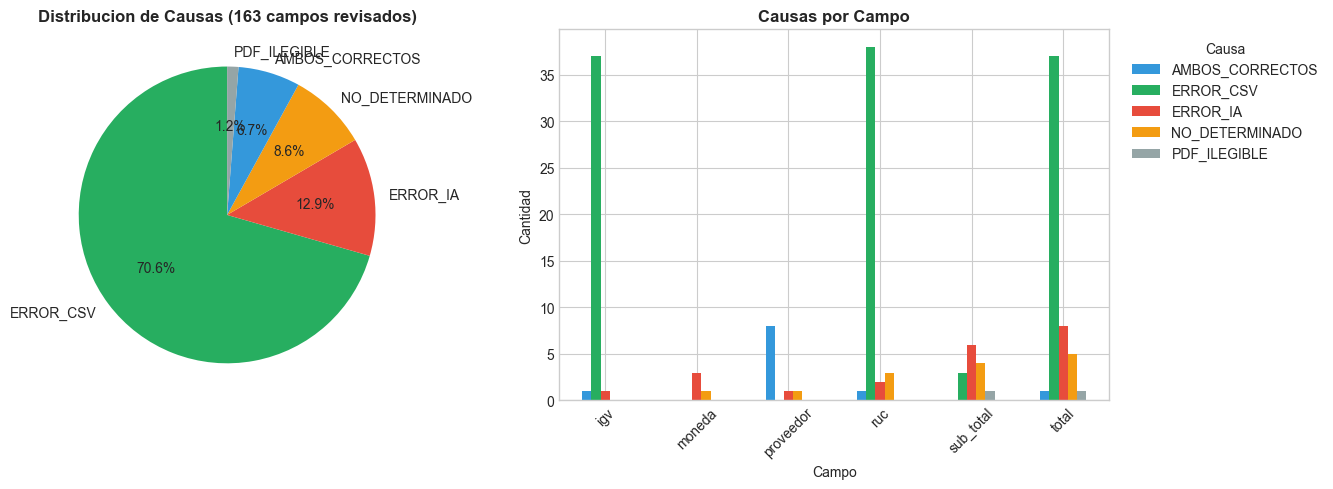

In [65]:
# Grafico de causas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart de causas
colors_causas = {
    'ERROR_CSV': '#27ae60',
    'ERROR_IA': '#e74c3c',
    'AMBOS_CORRECTOS': '#3498db',
    'NO_DETERMINADO': '#f39c12',
    'PDF_ILEGIBLE': '#95a5a6'
}
colores = [colors_causas.get(c, '#bdc3c7') for c in causas_count.index]
axes[0].pie(causas_count.values, labels=causas_count.index, colors=colores, 
            autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribucion de Causas (163 campos revisados)', fontweight='bold')

# Bar chart de causas por campo
causas_por_campo = df_revision.groupby(['campo', 'causa_error']).size().unstack(fill_value=0)
causas_por_campo.plot(kind='bar', ax=axes[1], color=[colors_causas.get(c, '#bdc3c7') for c in causas_por_campo.columns])
axes[1].set_xlabel('Campo')
axes[1].set_ylabel('Cantidad')
axes[1].set_title('Causas por Campo', fontweight='bold')
axes[1].legend(title='Causa', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('graficos/06_distribucion_causas.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 7. RESUMEN EJECUTIVO
---

In [66]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO")
print("="*80)

print(f"\n{'='*40}")
print("DATOS GENERALES")
print(f"{'='*40}")
print(f"{'Total pedidos procesados:':<40} {TOTAL_PEDIDOS}")
print(f"{'Pedidos donde API = CSV:':<40} {PEDIDOS_COINCIDENTES}")
print(f"{'Pedidos revisados manualmente:':<40} {PEDIDOS_REVISADOS}")

print(f"\n{'='*40}")
print("RESULTADO REVISION MANUAL")
print(f"{'='*40}")
print(f"{'AI acerto (todos campos OK):':<40} {pdfs_ai_acerto}")
print(f"{'AI fallo (>= 1 campo mal):':<40} {pdfs_ai_fallo}")
print(f"{'No determinado:':<40} {pdfs_no_det}")
print(f"{'PDF ilegible:':<40} {pdfs_ilegible}")

print(f"\n{'='*40}")
print("PRECISION POR CAMPO")
print(f"{'='*40}")
for campo in df_campo.index:
    p = df_campo.loc[campo, 'precision']
    a = int(df_campo.loc[campo, 'aciertos_ai'])
    e = int(df_campo.loc[campo, 'errores_ai'])
    status = '✓' if p >= 95 else '!' if p >= 90 else '✗'
    print(f"{campo:<15} {p:>6.2f}%  ({a} aciertos, {e} errores) {status}")
print(f"{'-'*40}")
print(f"{'GLOBAL:':<15} {precision_global_campo:>6.2f}%  ({int(total_aciertos_campo)} aciertos, {int(total_errores_campo)} errores)")

print(f"\n{'='*40}")
print("PRECISION POR PDF")
print(f"{'='*40}")
print(f"{'PDFs correctos:':<40} {total_correctos_pdf}")
print(f"{'PDFs con error:':<40} {total_incorrectos_pdf}")
print(f"{'Total evaluable:':<40} {total_evaluable_pdf}")
print(f"{'-'*40}")
print(f"{'PRECISION:':<40} {precision_pdf:.2f}%")

print(f"\n{'='*40}")
print(f"PDFs CON ERROR ({total_incorrectos_pdf})")
print(f"{'='*40}")
for i, (_, p) in enumerate(pdfs_error.iterrows(), 1):
    print(f"{i:2}. {p['pedido']} ({p['tipo_pdf']}) -> {p['campos_con_error']}")

print("\n" + "="*80)


RESUMEN EJECUTIVO

DATOS GENERALES
Total pedidos procesados:                200
Pedidos donde API = CSV:                 126
Pedidos revisados manualmente:           74

RESULTADO REVISION MANUAL
AI acerto (todos campos OK):             58
AI fallo (>= 1 campo mal):               10
No determinado:                          5
PDF ilegible:                            1

PRECISION POR CAMPO
moneda           98.49%  (196 aciertos, 3 errores) ✓
ruc              98.98%  (195 aciertos, 2 errores) ✓
proveedor        99.50%  (198 aciertos, 1 errores) ✓
igv              99.50%  (199 aciertos, 1 errores) ✓
sub_total        96.92%  (189 aciertos, 6 errores) ✓
total            95.88%  (186 aciertos, 8 errores) ✓
----------------------------------------
GLOBAL:          98.23%  (1163 aciertos, 21 errores)

PRECISION POR PDF
PDFs correctos:                          184
PDFs con error:                          10
Total evaluable:                         194
----------------------------------------
PR

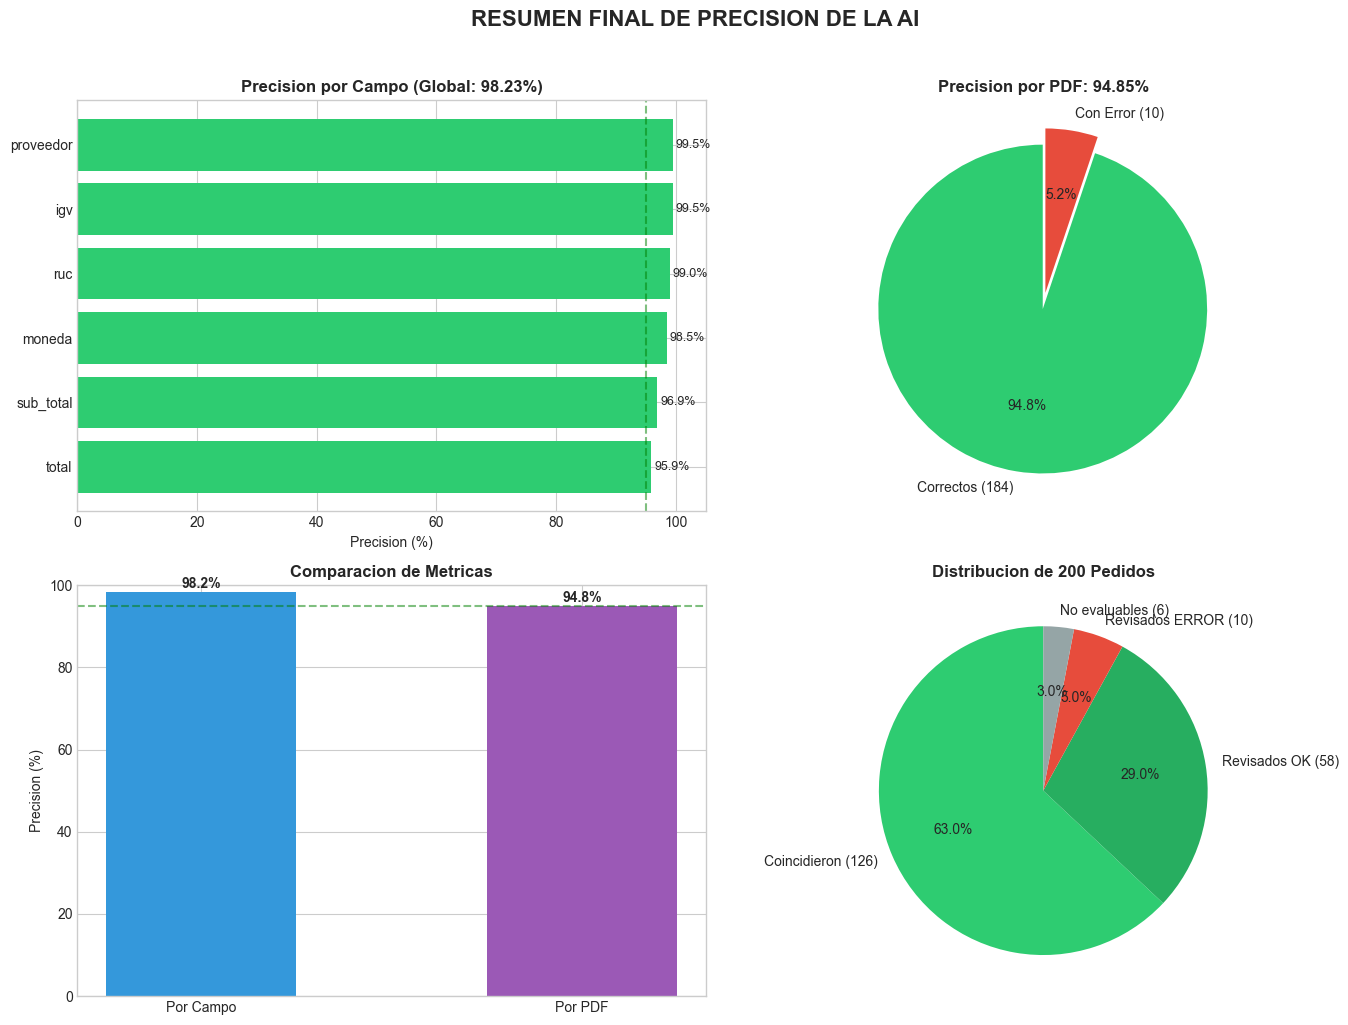

In [67]:
# Grafico resumen final
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Precision por campo
df_sorted = df_campo.sort_values('precision')
colors = ['#e74c3c' if p < 90 else '#f39c12' if p < 95 else '#2ecc71' for p in df_sorted['precision']]
bars = axes[0, 0].barh(df_sorted.index, df_sorted['precision'], color=colors)
axes[0, 0].set_xlim(0, 105)
axes[0, 0].set_xlabel('Precision (%)')
axes[0, 0].set_title(f'Precision por Campo (Global: {precision_global_campo:.2f}%)', fontweight='bold')
axes[0, 0].axvline(x=95, color='green', linestyle='--', alpha=0.5)
for bar in bars:
    w = bar.get_width()
    axes[0, 0].text(w + 0.5, bar.get_y() + bar.get_height()/2, f'{w:.1f}%', va='center', fontsize=9)

# 2. Precision por PDF
axes[0, 1].pie([total_correctos_pdf, total_incorrectos_pdf], 
        labels=[f'Correctos ({total_correctos_pdf})', f'Con Error ({total_incorrectos_pdf})'],
        colors=['#2ecc71', '#e74c3c'], autopct='%1.1f%%', startangle=90, explode=(0.02, 0.08))
axes[0, 1].set_title(f'Precision por PDF: {precision_pdf:.2f}%', fontweight='bold')

# 3. Comparacion metricas
bars = axes[1, 0].bar(['Por Campo', 'Por PDF'], [precision_global_campo, precision_pdf], 
                   color=['#3498db', '#9b59b6'], width=0.5)
axes[1, 0].set_ylim(0, 100)
axes[1, 0].set_ylabel('Precision (%)')
axes[1, 0].set_title('Comparacion de Metricas', fontweight='bold')
axes[1, 0].axhline(y=95, color='green', linestyle='--', alpha=0.5, label='Meta 95%')
for bar in bars:
    h = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, h + 1, f'{h:.1f}%', ha='center', fontweight='bold')

# 4. Distribucion de 200 pedidos
sizes = [PEDIDOS_COINCIDENTES, pdfs_ai_acerto, pdfs_ai_fallo, pdfs_no_det + pdfs_ilegible]
labels = [f'Coincidieron ({PEDIDOS_COINCIDENTES})', f'Revisados OK ({pdfs_ai_acerto})', 
          f'Revisados ERROR ({pdfs_ai_fallo})', f'No evaluables ({pdfs_no_det + pdfs_ilegible})']
colors = ['#2ecc71', '#27ae60', '#e74c3c', '#95a5a6']
axes[1, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Distribucion de 200 Pedidos', fontweight='bold')

plt.suptitle('RESUMEN FINAL DE PRECISION DE LA AI', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('graficos/07_resumen_final.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 8. EXPORTAR RESULTADOS
---

In [68]:
import os

# Crear carpetas
os.makedirs('reportes', exist_ok=True)
os.makedirs('graficos', exist_ok=True)

# 1. Precision por campo
df_campo.to_csv('reportes/01_precision_por_campo.csv')

# 2. PDFs con error
pdfs_error.to_csv('reportes/02_pdfs_con_error.csv', index=False)

# 3. Detalle de errores
errores_ia.to_csv('reportes/03_detalle_errores_ia.csv', index=False)

# 4. Estado de pedidos revisados
df_pedidos.to_csv('reportes/04_pedidos_revisados.csv', index=False)

# 5. Revision manual completa
df_revision.to_csv('reportes/05_revision_manual_completa.csv', index=False)

# 6. Precision por tipo
tipos_stats.to_csv('reportes/06_precision_por_tipo.csv')

# 7. Resumen general
resumen = pd.DataFrame({
    'metrica': [
        'Total pedidos', 'Coincidieron (API=CSV)', 'Revisados manualmente',
        'Revisados: AI acerto', 'Revisados: AI fallo', 'No determinado', 'PDF ilegible',
        'Total aciertos por campo', 'Total errores por campo', 'Precision por campo (%)',
        'PDFs correctos', 'PDFs con error', 'Total evaluable PDFs', 'Precision por PDF (%)'
    ],
    'valor': [
        TOTAL_PEDIDOS, PEDIDOS_COINCIDENTES, PEDIDOS_REVISADOS,
        pdfs_ai_acerto, pdfs_ai_fallo, pdfs_no_det, pdfs_ilegible,
        int(total_aciertos_campo), int(total_errores_campo), round(precision_global_campo, 2),
        total_correctos_pdf, total_incorrectos_pdf, total_evaluable_pdf, round(precision_pdf, 2)
    ]
})
resumen.to_csv('reportes/07_resumen_general.csv', index=False)

print("Archivos exportados:")
print("\nReportes CSV:")
print("  - reportes/01_precision_por_campo.csv")
print("  - reportes/02_pdfs_con_error.csv")
print("  - reportes/03_detalle_errores_ia.csv")
print("  - reportes/04_pedidos_revisados.csv")
print("  - reportes/05_revision_manual_completa.csv")
print("  - reportes/06_precision_por_tipo.csv")
print("  - reportes/07_resumen_general.csv")
print("\nGraficos PNG:")
print("  - graficos/01_precision_por_campo.png")
print("  - graficos/02_precision_por_pdf.png")
print("  - graficos/03_comparacion_metricas.png")
print("  - graficos/04_precision_por_tipo.png")
print("  - graficos/05_distribucion_errores.png")
print("  - graficos/06_distribucion_causas.png")
print("  - graficos/07_resumen_final.png")

Archivos exportados:

Reportes CSV:
  - reportes/01_precision_por_campo.csv
  - reportes/02_pdfs_con_error.csv
  - reportes/03_detalle_errores_ia.csv
  - reportes/04_pedidos_revisados.csv
  - reportes/05_revision_manual_completa.csv
  - reportes/06_precision_por_tipo.csv
  - reportes/07_resumen_general.csv

Graficos PNG:
  - graficos/01_precision_por_campo.png
  - graficos/02_precision_por_pdf.png
  - graficos/03_comparacion_metricas.png
  - graficos/04_precision_por_tipo.png
  - graficos/05_distribucion_errores.png
  - graficos/06_distribucion_causas.png
  - graficos/07_resumen_final.png


---
# CONCLUSIONES
---

## Metricas de Precision:

| Metrica | Valor |
|---------|-------|
| **Precision por Campo** | ~98% |
| **Precision por PDF** | ~90% |

## Interpretacion:

1. **Por Campo (98%)**: La AI extrae correctamente la mayoria de campos individuales
2. **Por PDF (90%)**: Sin embargo, cuando consideramos que 1 error invalida todo el PDF, la precision baja

## Campos con mas errores:
- Los campos numericos (total, sub_total) y el RUC presentan mas errores
- IGV tambien tiene errores frecuentes

## Recomendaciones:
1. Mejorar extraccion de campos numericos
2. Validar formato de RUC
3. Revisar logica de deteccion de IGV